In [274]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import pacf
import datetime
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam,SGD

In [275]:
def plot_series(df,format='-',start = 0, end = None):
    plt.plot(df['Umsatz'],format)
    plt.xlabel("Time")
    plt.ylabel("sales")
    plt.grid(True)

In [276]:
dataframe = pd.read_csv('meteolytix_Corona_bakery_turnover_updated.csv')

dataframe['Datum']=pd.to_datetime(dataframe['Datum'])

dataframe['Quarter'] = dataframe['Datum'].apply(lambda x: x.quarter)
dataframe['DayofTheWeek'] = dataframe['Datum'].apply(lambda x: x.weekday()+1)


In [277]:
cdf = pd.read_csv('covid-data.csv')
cdf['date'] = pd.to_datetime(cdf['date'])

cdf.rename(columns={'date':'Datum'},inplace=True)

cdf = cdf[['Datum','total_cases','new_cases','total_cases_per_million','new_cases_per_million']]

In [278]:
dataframe = dataframe.join(cdf.set_index('Datum'),on='Datum')

In [279]:
dataframe[['total_cases','new_cases','total_cases_per_million','new_cases_per_million']]= dataframe[['total_cases','new_cases','total_cases_per_million','new_cases_per_million']].fillna(0)

In [310]:
prodG1 = dataframe[dataframe['Warengruppe'] == 1]
prodG2 = dataframe[dataframe['Warengruppe'] == 2]
prodG3 = dataframe[dataframe['Warengruppe'] == 3]
prodG4 = dataframe[dataframe['Warengruppe'] == 4]
prodG5 = dataframe[dataframe['Warengruppe'] == 5]
prodG6 = dataframe[dataframe['Warengruppe'] == 6]

In [311]:
prodG1.drop('Warengruppe',axis=1,inplace=True) 
prodG2.drop('Warengruppe',axis=1,inplace=True) 
prodG3.drop('Warengruppe',axis=1,inplace=True) 
prodG4.drop('Warengruppe',axis=1,inplace=True) 
prodG5.drop('Warengruppe',axis=1,inplace=True) 
prodG6.drop('Warengruppe',axis=1,inplace=True) 

In [312]:
prodG1.set_index('Datum',inplace=True)
prodG2.set_index('Datum',inplace=True)
prodG3.set_index('Datum',inplace=True)
prodG4.set_index('Datum',inplace=True)
prodG5.set_index('Datum',inplace=True)
prodG6.set_index('Datum',inplace=True)

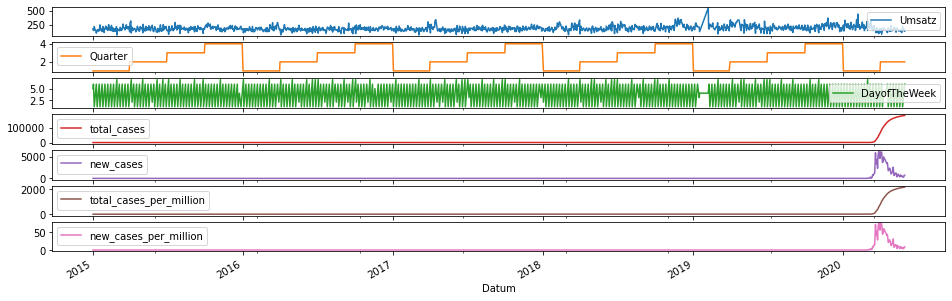

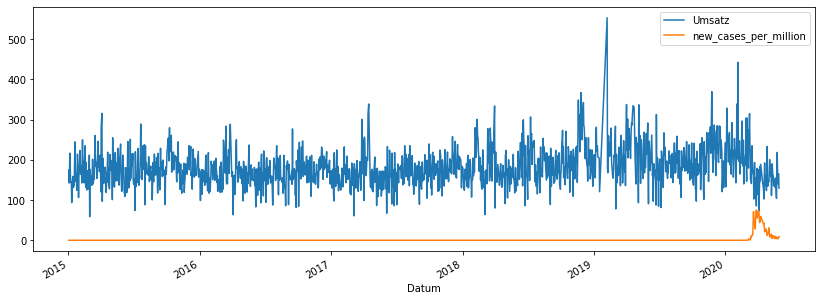

In [283]:
prodG1.plot(subplots=True,figsize=(16,5))
prodG1.plot(y=['Umsatz','new_cases_per_million'],figsize=(14,5))

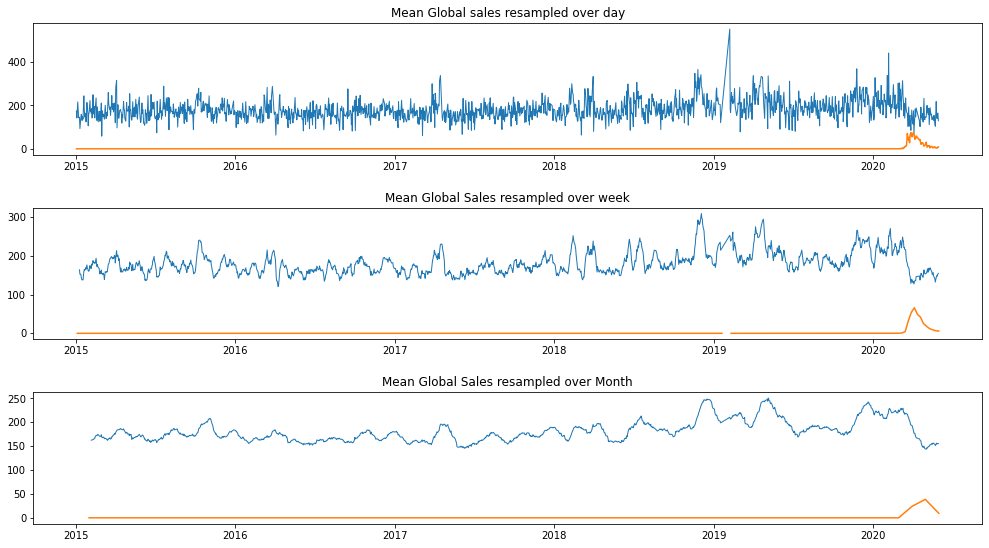

In [284]:
fig = plt.figure(figsize=(17,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
#ax1.plot(prodG1['Umsatz'].resample('D').mean(),linewidth=1)
ax1.plot(prodG1['Umsatz'].rolling(window=1).mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')
ax1.plot(prodG1['new_cases_per_million'])

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(prodG1['Umsatz'].rolling(window=7).mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')
ax2.plot(prodG1['new_cases_per_million'].resample('W').mean())

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(prodG1['Umsatz'].rolling(window=30).mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over Month')
ax3.tick_params(axis='both', which='major')
ax3.plot(prodG1['new_cases_per_million'].resample('M').mean())


In [252]:
meanprodG1 = prodG1
meanprodG1['Umsatz'] = meanprodG1['Umsatz'].rolling(window=14).mean()
meanprodG1['Umsatz'] = meanprodG1['Umsatz'].fillna(0)
meanprodG1.reset_index(inplace=True)
meanprodG1.head()

,Datum,Umsatz,Quarter,DayofTheWeek,total_cases,new_cases,total_cases_per_million,new_cases_per_million
0,2015-01-02,0.0,1,5,0.0,0.0,0.0,0.0
1,2015-01-03,0.0,1,6,0.0,0.0,0.0,0.0
2,2015-01-05,0.0,1,1,0.0,0.0,0.0,0.0
3,2015-01-06,0.0,1,2,0.0,0.0,0.0,0.0
4,2015-01-07,0.0,1,3,0.0,0.0,0.0,0.0


In [253]:
    dataset = meanprodG1.Umsatz.values 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = 1300
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [254]:
def create_dataset(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size), 0]
        X.append(a)
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

In [255]:
window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [256]:
X_train.shape


(1285, 14)

In [257]:
Y_train.shape

(1285,)

In [258]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [116]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation='relu',
                         input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(50,return_sequences=True),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, Y_train, epochs=100,callbacks=[lr_schedule])


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 1, 32)             2272      
_________________________________________________________________
lstm_32 (LSTM)               (None, 1, 50)             16600     
_________________________________________________________________
lstm_33 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_44 (Dense)             (None, 128)               6528      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_18 (Lambda)           (None, 1)               

(1e-08, 0.1, 0.0001, 0.002)

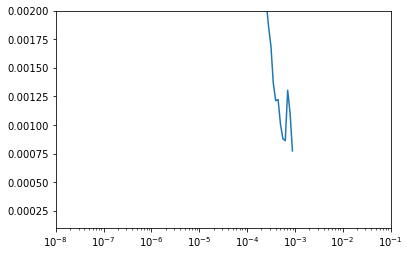

In [119]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0.0001, 0.002])

In [133]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation='relu',
                         input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(50,return_sequences=True),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#model.summary()

model.compile(loss='mse',
                  optimizer=Adam(lr = 1e-5),
                  metrics=["mae"]
                  )


history = model.fit(X_train, Y_train, epochs=300, batch_size=30, validation_data=(X_test, Y_test), 
                     verbose=2, shuffle=False)


Train on 1285 samples, validate on 347 samples
Epoch 1/300
1285/1285 - 6s - loss: 0.3235 - mae: 0.4421 - val_loss: 0.0253 - val_mae: 0.1299
Epoch 2/300
1285/1285 - 0s - loss: 0.0780 - mae: 0.2139 - val_loss: 0.0356 - val_mae: 0.1489
Epoch 3/300
1285/1285 - 0s - loss: 0.0711 - mae: 0.2032 - val_loss: 0.0297 - val_mae: 0.1360
Epoch 4/300
1285/1285 - 0s - loss: 0.0634 - mae: 0.1896 - val_loss: 0.0256 - val_mae: 0.1266
Epoch 5/300
1285/1285 - 0s - loss: 0.0590 - mae: 0.1864 - val_loss: 0.0207 - val_mae: 0.1142
Epoch 6/300
1285/1285 - 0s - loss: 0.0559 - mae: 0.1841 - val_loss: 0.0199 - val_mae: 0.1121
Epoch 7/300
1285/1285 - 0s - loss: 0.0514 - mae: 0.1737 - val_loss: 0.0168 - val_mae: 0.1032
Epoch 8/300
1285/1285 - 0s - loss: 0.0474 - mae: 0.1677 - val_loss: 0.0150 - val_mae: 0.0979
Epoch 9/300
1285/1285 - 0s - loss: 0.0438 - mae: 0.1614 - val_loss: 0.0123 - val_mae: 0.0898
Epoch 10/300
1285/1285 - 0s - loss: 0.0379 - mae: 0.1534 - val_loss: 0.0097 - val_mae: 0.0796
Epoch 11/300
1285/1285

Epoch 86/300
1285/1285 - 0s - loss: 9.9105e-04 - mae: 0.0237 - val_loss: 6.9223e-04 - val_mae: 0.0205
Epoch 87/300
1285/1285 - 0s - loss: 0.0011 - mae: 0.0238 - val_loss: 6.6938e-04 - val_mae: 0.0199
Epoch 88/300
1285/1285 - 0s - loss: 9.4823e-04 - mae: 0.0229 - val_loss: 7.1371e-04 - val_mae: 0.0211
Epoch 89/300
1285/1285 - 0s - loss: 0.0010 - mae: 0.0238 - val_loss: 6.6970e-04 - val_mae: 0.0200
Epoch 90/300
1285/1285 - 0s - loss: 9.3403e-04 - mae: 0.0229 - val_loss: 6.9655e-04 - val_mae: 0.0204
Epoch 91/300
1285/1285 - 0s - loss: 8.8601e-04 - mae: 0.0224 - val_loss: 6.7674e-04 - val_mae: 0.0201
Epoch 92/300
1285/1285 - 0s - loss: 8.3683e-04 - mae: 0.0224 - val_loss: 7.2694e-04 - val_mae: 0.0209
Epoch 93/300
1285/1285 - 0s - loss: 8.8892e-04 - mae: 0.0228 - val_loss: 7.4912e-04 - val_mae: 0.0216
Epoch 94/300
1285/1285 - 0s - loss: 9.1050e-04 - mae: 0.0228 - val_loss: 6.7285e-04 - val_mae: 0.0200
Epoch 95/300
1285/1285 - 0s - loss: 7.7011e-04 - mae: 0.0213 - val_loss: 7.0937e-04 - val_

Epoch 166/300
1285/1285 - 0s - loss: 3.6157e-04 - mae: 0.0143 - val_loss: 5.7851e-04 - val_mae: 0.0188
Epoch 167/300
1285/1285 - 0s - loss: 4.6238e-04 - mae: 0.0156 - val_loss: 5.8059e-04 - val_mae: 0.0196
Epoch 168/300
1285/1285 - 0s - loss: 4.5135e-04 - mae: 0.0158 - val_loss: 5.4689e-04 - val_mae: 0.0186
Epoch 169/300
1285/1285 - 0s - loss: 4.1802e-04 - mae: 0.0154 - val_loss: 6.3298e-04 - val_mae: 0.0196
Epoch 170/300
1285/1285 - 0s - loss: 4.2123e-04 - mae: 0.0151 - val_loss: 6.1940e-04 - val_mae: 0.0206
Epoch 171/300
1285/1285 - 0s - loss: 4.8037e-04 - mae: 0.0165 - val_loss: 6.0117e-04 - val_mae: 0.0198
Epoch 172/300
1285/1285 - 0s - loss: 4.5541e-04 - mae: 0.0160 - val_loss: 6.1416e-04 - val_mae: 0.0193
Epoch 173/300
1285/1285 - 0s - loss: 4.1558e-04 - mae: 0.0151 - val_loss: 6.2236e-04 - val_mae: 0.0204
Epoch 174/300
1285/1285 - 0s - loss: 4.4396e-04 - mae: 0.0158 - val_loss: 5.3352e-04 - val_mae: 0.0185
Epoch 175/300
1285/1285 - 0s - loss: 4.8481e-04 - mae: 0.0156 - val_loss:

Epoch 246/300
1285/1285 - 0s - loss: 3.6981e-04 - mae: 0.0145 - val_loss: 4.2217e-04 - val_mae: 0.0158
Epoch 247/300
1285/1285 - 0s - loss: 3.4396e-04 - mae: 0.0142 - val_loss: 4.6014e-04 - val_mae: 0.0170
Epoch 248/300
1285/1285 - 0s - loss: 3.3238e-04 - mae: 0.0139 - val_loss: 4.4696e-04 - val_mae: 0.0171
Epoch 249/300
1285/1285 - 0s - loss: 3.6131e-04 - mae: 0.0144 - val_loss: 4.3372e-04 - val_mae: 0.0164
Epoch 250/300
1285/1285 - 0s - loss: 3.3487e-04 - mae: 0.0140 - val_loss: 5.2036e-04 - val_mae: 0.0176
Epoch 251/300
1285/1285 - 0s - loss: 3.8807e-04 - mae: 0.0144 - val_loss: 6.4271e-04 - val_mae: 0.0212
Epoch 252/300
1285/1285 - 0s - loss: 4.4231e-04 - mae: 0.0158 - val_loss: 4.7684e-04 - val_mae: 0.0177
Epoch 253/300
1285/1285 - 0s - loss: 3.3695e-04 - mae: 0.0141 - val_loss: 4.5836e-04 - val_mae: 0.0167
Epoch 254/300
1285/1285 - 0s - loss: 3.3974e-04 - mae: 0.0140 - val_loss: 4.5509e-04 - val_mae: 0.0167
Epoch 255/300
1285/1285 - 0s - loss: 3.2130e-04 - mae: 0.0137 - val_loss:

In [259]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])



In [260]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

Train Mean Absolute Error: 3.5779614444506462
Train Root Mean Squared Error: 4.507939930192378
Test Mean Absolute Error: 4.782165629775483
Test Root Mean Squared Error: 6.097336592226249


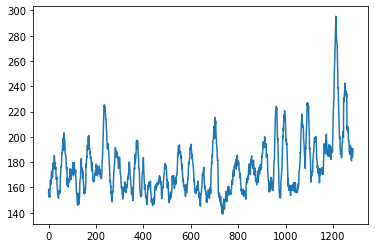

In [261]:
plt.plot(Y_train_Sca[0])

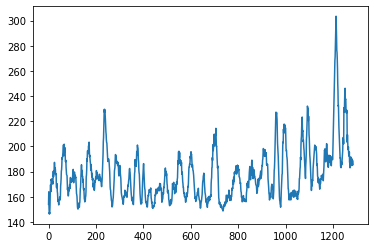

In [262]:
plt.plot(train_predict[:,0])

In [263]:
train_predict[:,0]

array([153.9647 , 163.85628, 151.78053, ..., 186.59009, 185.04752,
       188.30789], dtype=float32)

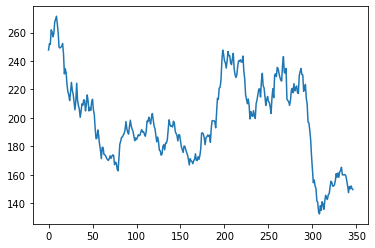

In [264]:
plt.plot(Y_test_Sca[0])

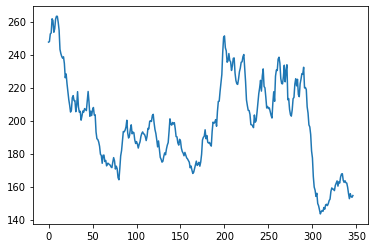

In [265]:
plt.plot(test_predict[:,0])

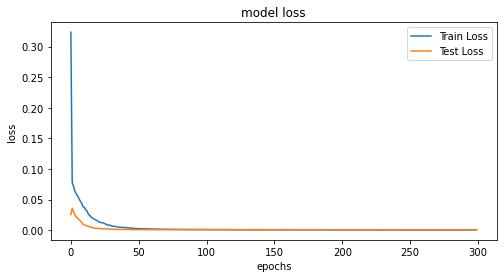

In [266]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

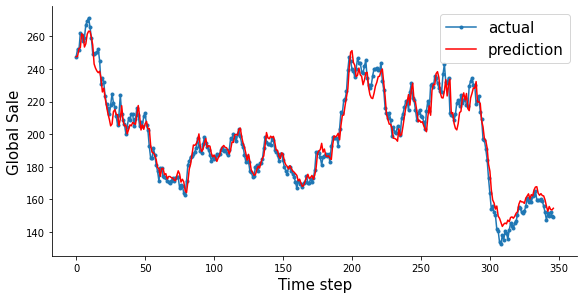

In [267]:
aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Train Mean Absolute Error: 4.5165580837773724
Train Root Mean Squared Error: 6.4169195971267765
Test Mean Absolute Error: 7.94400384310316
Test Root Mean Squared Error: 9.291660839280643


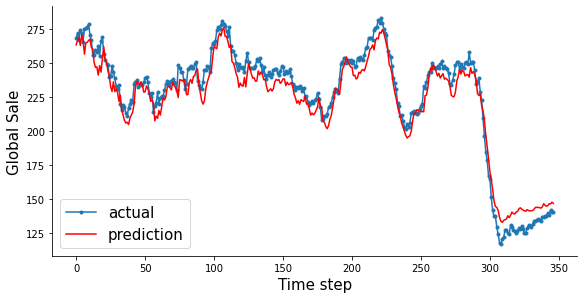

In [306]:
meanprodG2 = prodG2
meanprodG2['Umsatz'] = meanprodG2['Umsatz'].rolling(window=14).mean()
meanprodG2['Umsatz'] = meanprodG2['Umsatz'].fillna(0)
meanprodG2.reset_index(inplace=True)

dataset = meanprodG2.Umsatz.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 1300
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Train Mean Absolute Error: 4.320081366717087
Train Root Mean Squared Error: 6.211689159189146
Test Mean Absolute Error: 8.866787213924875
Test Root Mean Squared Error: 10.815540325205438


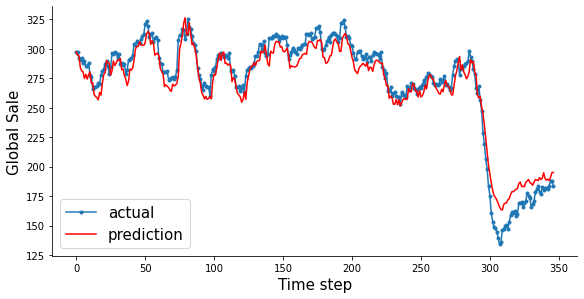

In [307]:
meanprodG3 = prodG3
meanprodG3['Umsatz'] = meanprodG3['Umsatz'].rolling(window=14).mean()
meanprodG3['Umsatz'] = meanprodG3['Umsatz'].fillna(0)
meanprodG3.reset_index(inplace=True)

dataset = meanprodG3.Umsatz.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 1300
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Train Mean Absolute Error: 4.471740096952168
Train Root Mean Squared Error: 6.002586446324165
Test Mean Absolute Error: 1.9372091771059174
Test Root Mean Squared Error: 2.545742877382198


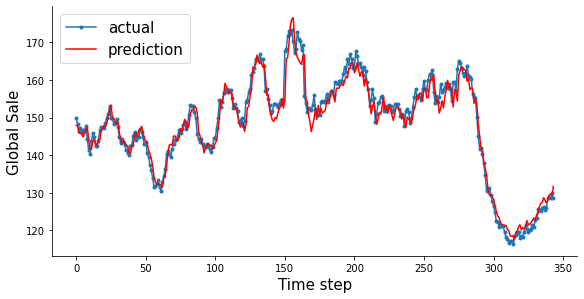

In [313]:
meanprodG4 = prodG4
meanprodG4['Umsatz'] = meanprodG4['Umsatz'].rolling(window=14).mean()
meanprodG4['Umsatz'] = meanprodG4['Umsatz'].fillna(0)
meanprodG4.reset_index(inplace=True)

dataset = meanprodG4.Umsatz.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 1300
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

aa=[x for x in range(344)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:344], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:344], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Train Mean Absolute Error: 6.293601683448614
Train Root Mean Squared Error: 9.87314957824979
Test Mean Absolute Error: 7.2121724791564645
Test Root Mean Squared Error: 10.83397870106531


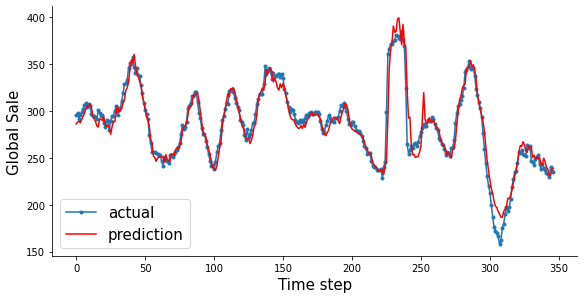

In [314]:
meanprodG5 = prodG5
meanprodG5['Umsatz'] = meanprodG5['Umsatz'].rolling(window=14).mean()
meanprodG5['Umsatz'] = meanprodG5['Umsatz'].fillna(0)
meanprodG5.reset_index(inplace=True)

dataset = meanprodG5.Umsatz.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 1300
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Train Mean Absolute Error: 4.5099682717340945
Train Root Mean Squared Error: 5.743852493924948
Test Mean Absolute Error: 5.3209010643125065
Test Root Mean Squared Error: 7.478955936983998


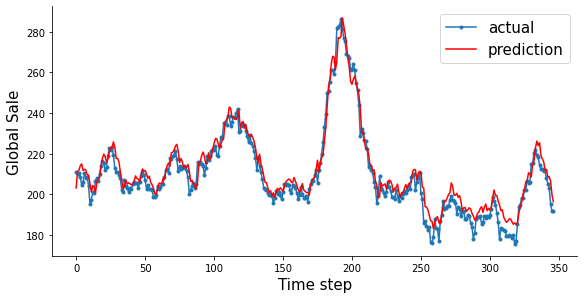

In [315]:
meanprodG6 = prodG6
meanprodG6['Umsatz'] = meanprodG6['Umsatz'].rolling(window=14).mean()
meanprodG6['Umsatz'] = meanprodG6['Umsatz'].fillna(0)
meanprodG6.reset_index(inplace=True)

dataset = meanprodG3.Umsatz.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = 50
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

window_size = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();